In [1]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [2]:
!pip install transformers

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
#from transformers import BertModel, BertConfig

# Initializing a BERT bert-base-uncased style configuration
#bert_configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
#bert_model = BertModel(bert_configuration)

# Accessing the model configuration
#bert_configuration = model.config

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
!pip install datasets
from datasets import Dataset

In [6]:
import pandas as pd
CleanedData= pd.read_csv('C:/Users/ddey4/Downloads/archive/Cleaned_Youtube.csv',index_col=0)
#Replace this with your login

In [7]:
#from huggingface_hub import notebook_login
#notebook_login()

In [8]:
ActualData = CleanedData[['No Punc Title','label']] 

In [9]:
ActualData.reset_index(drop = True, inplace = True)
ActualData
# Actual data has only text and label

,No Punc Title,label
0,we want to talk about our marriage,1
1,the trump presidency last week tonight with jo...,1
2,racist superman | rudy mancuso king bach lele...,1
3,nickelback lyrics real or fake,0
4,2 weeks with iphone x,0
...,...,...
64188,cyberpunk 2077 story open world and firstperso...,1
64189,masterchef | standup comedy by karunesh talwar,1
64190,how2 how to solve a mystery,0
64191,kingdom hearts iii – square enix e3 showcase 2...,1


In [10]:
dataset = Dataset.from_pandas(ActualData)
dataset

Dataset({
    features: ['No Punc Title', 'label'],
    num_rows: 64193
})

In [11]:
from datasets import DatasetDict
# 80% train, 20% test + validation
train_testvalid = dataset.train_test_split(test_size=0.2)
# Split the 20% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

dataset = train_test_valid_dataset

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['No Punc Title', 'label'],
        num_rows: 51354
    })
    test: Dataset({
        features: ['No Punc Title', 'label'],
        num_rows: 6420
    })
    valid: Dataset({
        features: ['No Punc Title', 'label'],
        num_rows: 6419
    })
})

In [13]:
#Preprocessing data -> tokenises and pads

In [14]:
def preprocess_function(examples):
    return tokenizer(examples["No Punc Title"], truncation=True,padding=True, max_length = 512)

In [15]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/52 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [16]:
tokenized_dataset["test"][0]

{'No Punc Title': 'why old buildings use the same leaf design',
 'label': 0,
 'input_ids': [101,
  2339,
  2214,
  3121,
  2224,
  1996,
  2168,
  7053,
  2640,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
tokenized_dataset["test"][0]

{'No Punc Title': 'why old buildings use the same leaf design',
 'label': 0,
 'input_ids': [101,
  2339,
  2214,
  3121,
  2224,
  1996,
  2168,
  7053,
  2640,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [19]:
! transformers-cli env
import numpy as np
from sklearn.metrics import accuracy_score , recall_score , precision_score ,f1_score


Copy-and-paste the text below in your GitHub issue and FILL OUT the two last points.

- `transformers` version: 4.18.0
- Platform: Windows-10-10.0.19041-SP0
- Python version: 3.8.8
- Huggingface_hub version: 0.5.1
- PyTorch version (GPU?): 1.11.0+cu113 (False)
- Tensorflow version (GPU?): not installed (NA)
- Flax version (CPU?/GPU?/TPU?): not installed (NA)
- Jax version: not installed
- JaxLib version: not installed
- Using GPU in script?: <fill in>
- Using distributed or parallel set-up in script?: <fill in>



In [20]:
def compute_metrics(p):
  pred, labels = p
  pred = np.argmax(pred,axis=1)
  accuracy = accuracy_score(y_true = labels,y_pred =pred)
  recall = recall_score(y_true = labels,y_pred =pred)
  precision = precision_score(y_true = labels,y_pred =pred)
  f1= f1_score(y_true = labels,y_pred =pred)
  return { "accuracy": accuracy ,"recall": recall,"precision": precision,"F1":f1 }

In [21]:
training_args = TrainingArguments(
    output_dir="bert-finetuned-youtube",
    evaluation_strategy= "steps",
    eval_steps = 500,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics = compute_metrics,

)

trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: No Punc Title. If No Punc Title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\ddey4\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 51354
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6420


Step,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
500,0.631500,0.556835,0.710903,0.728043,0.742725,0.735311
1000,0.548100,0.511580,0.757321,0.916125,0.720089,0.806363
1500,0.493600,0.442199,0.807944,0.885908,0.790973,0.835753
2000,0.454500,0.403723,0.819626,0.898334,0.799447,0.846011
2500,0.415100,0.385224,0.838941,0.911607,0.817422,0.861949
3000,0.396200,0.374426,0.849377,0.914996,0.829493,0.870149
3500,0.332400,0.358786,0.856075,0.902287,0.846806,0.873667
4000,0.284500,0.366079,0.864019,0.889862,0.867089,0.878328
4500,0.283500,0.356477,0.869159,0.899463,0.868084,0.883495
5000,0.284200,0.336484,0.868380,0.922621,0.851225,0.885486


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: No Punc Title. If No Punc Title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6420
  Batch size = 16
Saving model checkpoint to bert-finetuned-youtube\checkpoint-500
Configuration saved in bert-finetuned-youtube\checkpoint-500\config.json
Model weights saved in bert-finetuned-youtube\checkpoint-500\pytorch_model.bin
tokenizer config file saved in bert-finetuned-youtube\checkpoint-500\tokenizer_config.json
Special tokens file saved in bert-finetuned-youtube\checkpoint-500\special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: No Punc Title. If No Punc Title are not expected by `BertForSequenceClassification.forward`,  you can safe

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: No Punc Title. If No Punc Title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6420
  Batch size = 16
Saving model checkpoint to bert-finetuned-youtube\checkpoint-6000
Configuration saved in bert-finetuned-youtube\checkpoint-6000\config.json
Model weights saved in bert-finetuned-youtube\checkpoint-6000\pytorch_model.bin
tokenizer config file saved in bert-finetuned-youtube\checkpoint-6000\tokenizer_config.json
Special tokens file saved in bert-finetuned-youtube\checkpoint-6000\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from bert-finetuned-youtube\checkpoint-5000 (score: 0.33648377656936646).


TrainOutput(global_step=6420, training_loss=0.3815180769590574, metrics={'train_runtime': 60876.677, 'train_samples_per_second': 1.687, 'train_steps_per_second': 0.105, 'total_flos': 2839377342803280.0, 'train_loss': 0.3815180769590574, 'epoch': 2.0})

In [22]:
x= [500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000]
tloss = [ 0.631500 ,0.54810 ,0.493600 ,0.454500 , 0.415100 ,0.396200 ,0.332400 ,0.284500 ,0.283500,0.284200,0.269500 ,0.286100]
vloss =[0.556835,0.511580,0.442199,0.403723,0.385224,0.374426,0.358786,0.366079,0.356477,0.336484,0.353541,0.343387]


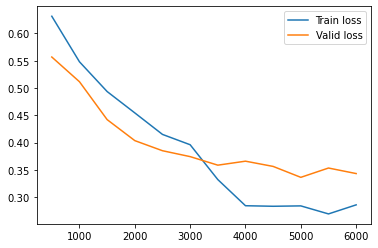

In [23]:
import matplotlib.pyplot as plt
plt.plot(x,tloss,label="Train loss")
plt.plot(x,vloss,label="Valid loss")
plt.legend()
plt.show()

In [24]:
##Making pred

# Make prediction
raw_pred,_,_ = trainer.predict(tokenized_dataset["valid"])

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)
y_test = tokenized_dataset["valid"]["label"]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: No Punc Title. If No Punc Title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 6419
  Batch size = 16


In [25]:
y_pred

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [26]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Metrics
print("Accuracy ",metrics.accuracy_score(y_test, y_pred)*100)
print("F1 Score ",metrics.f1_score(y_test, y_pred)*100)

Accuracy  85.71428571428571
F1 Score  87.65980352577041


Text(91.68, 0.5, 'predicted label')

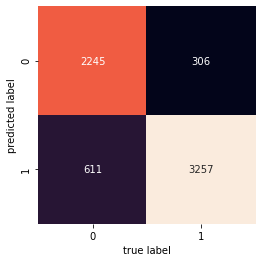

In [27]:
#Confustion Matrix heat map
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label')

In [28]:
#Classification Report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      2856
           1       0.84      0.91      0.88      3563

    accuracy                           0.86      6419
   macro avg       0.86      0.85      0.85      6419
weighted avg       0.86      0.86      0.86      6419

